# Collaborative filtering

In [1]:
%pylab inline

from collections import defaultdict
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans

from evaluator import Evaluator
from dataset_handler import DatasetHandler

Populating the interactive namespace from numpy and matplotlib


In [2]:
dataset100k = "datasets/ml-latest-small/"
dataset1M = "datasets/ml-1m"

In [3]:
dataset_handler = DatasetHandler(dataset100k)

In [4]:
class CollaborativeFilteringRecommender(object):
    def __init__(self, dataset_handler, neighbours_to_predict=5):
        self.dataset_handler = dataset_handler
        self.movies_vectors = self.dataset_handler.load_movies()
        self.movies_ids = set(self.dataset_handler.id_to_title.keys())
        self.neighbours_to_predict = neighbours_to_predict
    
    def train(self, train_set):
        self.users_ratings = train_set
        self.users_profiles, self.user_id_to_profile_index = self._create_users_profiles(train_set)
        self.movies_watchers = self._get_movies_watchers(train_set)
        self.nbrs = NearestNeighbors(metric='cosine', algorithm='brute')
    
    def top(self, user_profile, topN):
        unrated_movies = np.array([
            (movieId, self.predict_rating(user_profile, movieId))
            for movieId in list(self.movies_ids - user_profile[1])
        ])
        return unrated_movies[np.argpartition(-unrated_movies[:, 1], topN)[:topN], 0]
    
    def predict_rating(self, user_profile, movieId):
        profiles_with_ids = np.array([
            np.hstack([[watcher], self.users_profiles[self.user_id_to_profile_index[watcher]][0]])
            for watcher in self.movies_watchers[movieId]
        ])
        nearest_neighbours = self._cosineKNN(user_profile, profiles_with_ids, self.neighbours_to_predict)
        if not nearest_neighbours:
            return 0.0
        return np.average([self.users_ratings[neighbour][movieId] for neighbour in nearest_neighbours])
    
    def create_user_profile(self, user_ratings):
        mid_rating=2.75
        profile = np.average(
            np.array([
                self.movies_vectors[self.dataset_handler.id2index(movie)]*np.sign(rating - mid_rating)
                for (movie, rating) in user_ratings.items()
            ]),
            weights=(mid_rating-np.array(user_ratings.values()))**2,
            axis=0
        )
        watched_movies = set(user_ratings.keys())
        return (profile, watched_movies)
    
    def present_user(self, user_profile, user_ratings):
        print "User favourite genre:", self.dataset_handler.feature_index2genre(np.argmax(user_profile[0]))
        print "User ratings:"
        for (movieId, rating) in user_ratings.items():
            movie_vector = self.movies_vectors[self.dataset_handler.id2index(movieId)]
            print "{} {}: {}".format(
                self.dataset_handler.id_to_title[movieId],
                self.dataset_handler.movie_vector2genres(movie_vector),
                rating
            )
    
    def present_recommendations(self, recommendations):
        print "Recommended movies:"
        for movieId in recommendations:
            movie_vector = self.movies_vectors[self.dataset_handler.id2index(movieId)]
            print "{} {}".format(
                self.dataset_handler.id_to_title[movieId],
                self.dataset_handler.movie_vector2genres(movie_vector)
            )
    
    def _get_movies_watchers(self, users_ratings):
        movies_watchers = defaultdict(list)
        for (user, user_ratings) in users_ratings.items():
            for movieId in user_ratings.keys():
                movies_watchers[movieId].append(user)
        return movies_watchers
    
    def _create_users_profiles(self, users_ratings):
        users_profiles = []
        user_id_to_profile_index = {}
        for i, (user, user_ratings) in enumerate(users_ratings.items()):
            users_profiles.append(self.create_user_profile(user_ratings))
            user_id_to_profile_index[user] = i
        return users_profiles, user_id_to_profile_index
    
    def _cosineKNN(self, user_profile, profiles_with_ids, k, treshold=20):
        if profiles_with_ids.shape[0] < treshold:
            return []
        self.nbrs.fit(profiles_with_ids[:, 1:])
        return [
            profiles_with_ids[i, 0]
            for i in self.nbrs.kneighbors(np.array([user_profile[0]]), n_neighbors=min(k, len(profiles_with_ids)), return_distance=False)[0]
        ]

In [5]:
recommender = CollaborativeFilteringRecommender(dataset_handler, 20)
users_ratings = dataset_handler.load_users_ratings()
user_ratings = users_ratings[1]
del users_ratings[1]
recommender.train(users_ratings)
user_profile = recommender.create_user_profile(user_ratings)
recommender.present_user(user_profile, user_ratings)

User favourite genre: Action
User ratings:
French Connection, The (1971) ['Action', 'Crime', 'Thriller']: 4.0
Dracula (Bram Stoker's Dracula) (1992) ['Fantasy', 'Horror', 'Romance', 'Thriller']: 3.5
Sleepers (1996) ['Thriller']: 3.0
Gods Must Be Crazy, The (1980) ['Adventure', 'Comedy']: 3.0
Ben-Hur (1959) ['Action', 'Adventure', 'Drama']: 2.0
Willow (1988) ['Action', 'Adventure', 'Fantasy']: 2.0
Escape from New York (1981) ['Action', 'Adventure', 'Sci-Fi', 'Thriller']: 2.0
Blazing Saddles (1974) ['Comedy', 'Western']: 3.0
Gandhi (1982) ['Drama']: 2.0
Deer Hunter, The (1978) ['Drama', 'War']: 2.0
Cape Fear (1991) ['Thriller']: 2.0
Cinema Paradiso (Nuovo cinema Paradiso) (1989) ['Drama']: 4.0
Antz (1998) ['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy']: 2.0
Fly, The (1986) ['Drama', 'Horror', 'Sci-Fi', 'Thriller']: 2.5
Time Bandits (1981) ['Adventure', 'Comedy', 'Fantasy', 'Sci-Fi']: 1.0
Tron (1982) ['Action', 'Adventure', 'Sci-Fi']: 4.0
Star Trek: The Motion Picture (1979) [

In [6]:
top = recommender.top(user_profile, topN=5)
recommender.present_recommendations(top)

Recommended movies:
Godfather: Part II, The (1974) ['Crime', 'Drama']
Raging Bull (1980) ['Drama']
Godfather, The (1972) ['Crime', 'Drama']
Rear Window (1954) ['Mystery', 'Thriller']
On the Waterfront (1954) ['Crime', 'Drama']


In [7]:
evaluator = Evaluator(CollaborativeFilteringRecommender(dataset_handler, 20))
evaluator.computeRMSE()

0.75211346032869619

In [8]:
evaluator.computeMAP()

0.16823288690476218

In [9]:
class CollaborativeFilteringWithClusteringRecommender(CollaborativeFilteringRecommender):
    def __init__(self, dataset_handler, neighbours_to_predict=5, clusters=10):
        super(CollaborativeFilteringWithClusteringRecommender, self).__init__(dataset_handler, neighbours_to_predict)
        self.clusters = clusters
    
    def train(self, train_set):
        self.users_ratings = train_set
        self.users_profiles, self.user_id_to_profile_index = self._create_users_profiles(train_set)
        self.kmeans = KMeans(n_clusters=self.clusters).fit(np.array([profile for (profile, _) in self.users_profiles]))
        self.movies_watchers = self._get_movies_watchers(train_set)
        self.nbrs = NearestNeighbors(metric='cosine', algorithm='brute')
    
    def predict_rating(self, user_profile, movieId):
        nearest_group = self.kmeans.predict(np.array([user_profile[0]]))[0]
        profiles_with_ids = np.array([
            np.hstack([[watcher], self.users_profiles[self.user_id_to_profile_index[watcher]][0]])
            for watcher in self.movies_watchers[movieId]
            if self.kmeans.labels_[self.user_id_to_profile_index[watcher]] == nearest_group
        ])
        nearest_neighbours = self._cosineKNN(user_profile, profiles_with_ids, self.neighbours_to_predict)
        if not nearest_neighbours:
            return 0.0
        return np.average([self.users_ratings[neighbour][movieId] for neighbour in nearest_neighbours])

In [10]:
recommender = CollaborativeFilteringWithClusteringRecommender(dataset_handler, 5, 10)
users_ratings = dataset_handler.load_users_ratings()
user_ratings = users_ratings[1]
del users_ratings[1]
recommender.train(users_ratings)
user_profile = recommender.create_user_profile(user_ratings)
recommender.present_user(user_profile, user_ratings)

User favourite genre: Action
User ratings:
French Connection, The (1971) ['Action', 'Crime', 'Thriller']: 4.0
Dracula (Bram Stoker's Dracula) (1992) ['Fantasy', 'Horror', 'Romance', 'Thriller']: 3.5
Sleepers (1996) ['Thriller']: 3.0
Gods Must Be Crazy, The (1980) ['Adventure', 'Comedy']: 3.0
Ben-Hur (1959) ['Action', 'Adventure', 'Drama']: 2.0
Willow (1988) ['Action', 'Adventure', 'Fantasy']: 2.0
Escape from New York (1981) ['Action', 'Adventure', 'Sci-Fi', 'Thriller']: 2.0
Blazing Saddles (1974) ['Comedy', 'Western']: 3.0
Gandhi (1982) ['Drama']: 2.0
Deer Hunter, The (1978) ['Drama', 'War']: 2.0
Cape Fear (1991) ['Thriller']: 2.0
Cinema Paradiso (Nuovo cinema Paradiso) (1989) ['Drama']: 4.0
Antz (1998) ['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy']: 2.0
Fly, The (1986) ['Drama', 'Horror', 'Sci-Fi', 'Thriller']: 2.5
Time Bandits (1981) ['Adventure', 'Comedy', 'Fantasy', 'Sci-Fi']: 1.0
Tron (1982) ['Action', 'Adventure', 'Sci-Fi']: 4.0
Star Trek: The Motion Picture (1979) [

In [11]:
top = recommender.top(user_profile, topN=5)
recommender.present_recommendations(top)

Recommended movies:
That's Entertainment! III (1994) ['Documentary']
That's Entertainment, Part II (1976) ['Documentary']
Wackiest Ship in the Army, The (1960) ['Comedy', 'War']
Fire in the Sky (1993) ['Drama', 'Mystery', 'Sci-Fi']
That's Entertainment (1974) ['Documentary']


In [12]:
clusters = [5, 10, 20, 50]
maps, rmses = [], []
for cluster in clusters:
    evaluator = Evaluator(CollaborativeFilteringWithClusteringRecommender(dataset_handler, 5, cluster))
    rmses.append(evaluator.computeRMSE())
    print "Done"
    maps.append(evaluator.computeMAP())

Done
Done
Done
Done


Highest MAP 0.27144229177 for n_clusters = 10
[0.227418276374443, 0.2714422917701608, 0.1320130621693123]


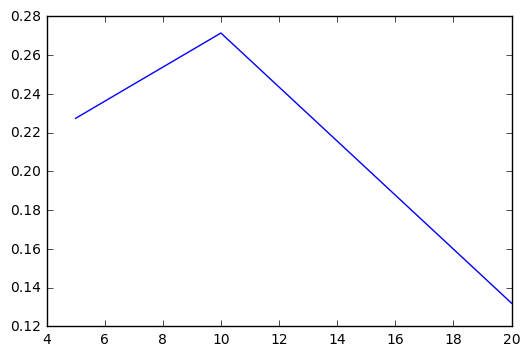

In [16]:
print "Highest MAP {} for n_clusters = {}".format(max(maps), clusters[argmax(maps)])
print maps
plot(clusters, maps)

Lowest RMSE 0.63492030492 for n_clusters = 10
[0.7571246587807078, 0.6349203049203044, 0.7794639556377088]


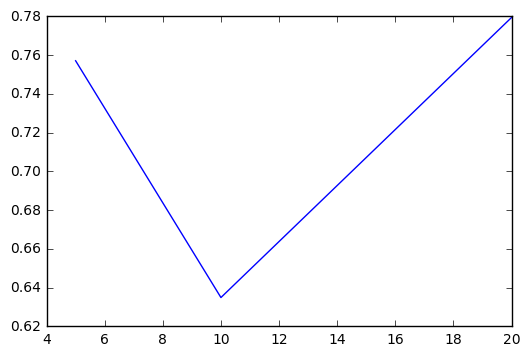

In [17]:
print "Lowest RMSE {} for n_clusters = {}".format(min(rmses), clusters[argmin(rmses)])
print rmses
plot(clusters, rmses)